In [1]:
import os
import matplotlib.pyplot as plt

In [27]:
import os
import json
import pandas as pd
import tqdm

# read file
data_dir = "../../external_projects/bva-citation-prediction/data/preprocessed-cached/preprocessed-cached-v4/"
# get list of filepaths in data_dir
filepaths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')][:10000]

dfs = [] # an empty list to store the data frames
for file in tqdm.tqdm(filepaths):
    data = pd.read_json(file, lines=True) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True)
df.head()


100%|██████████| 10000/10000 [00:29<00:00, 333.80it/s]


,bva_id,txt,citation_texts,citation_vocab,citation_indices
0,1424982,citation nr 1424982 decision date 06 03 14 arc...,"[38 C.F.R. § 20.900(c), 38 U.S.C.A. § 7107(a)(...","[[38 C.F.R. §, 38 C.F.R. 20.900, 38 C.F.R.], [...","[[84], [85], [45], [49, 441], [45, 55], [123],..."
1,938336,citation nr 0938336 decision date 10 08 09 arc...,"[38 U.S.C.A. §§ 1101, 1110, 1111, 1112, 1113, ...","[[38 U.S.C.A. §§, 38 U.S.C.A. 1101, 38 U.S.C.A...","[[44, 45, 155, 46, 47, 48], [49, 50, 51], [22,..."
2,1645294,citation nr 1645294 decision date 12 01 16 arc...,"[38 U.S.C.A. § 7104(a), 38 C.F.R. § 20.904, 38...","[[38 U.S.C.A. §, 38 U.S.C.A. 7104, 38 U.S.C.A....","[[77], [726], [422]]"
3,1531665,citation nr 1531665 decision date 07 24 15 arc...,"[Kutscherousky v. West, 12 Vet. App. 369 (1999...","[[Kutscherousky_12 Vet. App. 369], [38 U.S.C.A...","[[3], [4, 5], [6], [7]]"
4,332177,citation nr 0332177 decision date 11 19 03 arc...,"[38 U.S.C. § 1151, See Fenderson v. West, 12 V...","[[38 U.S.C. §, 38 U.S.C. 1151], [Fenderson_12 ...","[[396], [86], [424], [54], [290], [1191], [1],..."


In [28]:
for i in range(4):
    print(df.loc[0]["citation_texts"][i])
    print(df.loc[0]["citation_vocab"][i])
    print(df.loc[0]["citation_indices"][i])
    print()

38 C.F.R. § 20.900(c)
['38 C.F.R. §', '38 C.F.R. 20.900', '38 C.F.R.']
[84]

38 U.S.C.A. § 7107(a)(2)
['38 U.S.C.A. §', '38 U.S.C.A. 7107', '38 U.S.C.A.', '38 U.S.C.A.']
[85]

38 U.S.C.A. § 1110
['38 U.S.C.A. §', '38 U.S.C.A. 1110']
[45]

38 C.F.R. §§ 3.303, 3.310
['38 C.F.R. §§', '38 C.F.R. 3.303', '38 C.F.R. ,', '38 C.F.R. 3.310']
[49, 441]



In [29]:
# return all occurences of str in string
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

df['num_citations'] = df['citation_vocab'].apply(lambda x: len(x))

## stats on number of citations

In [30]:
figures = [] # add all plotly figures here

In [31]:
import plotly.express as px
fig = px.histogram(df, x="num_citations", nbins=50)
# title
fig.update_layout(title_text="Number of citations per paper")
fig.show()
figures.append(fig)

In [32]:
# percentiles
percentiles = [i/10 for i in range(0, 10)]
citations_per_percentile = df['num_citations'].quantile(percentiles)
# create the same scatter plot in plotly
fig = px.scatter(x=percentiles, y=citations_per_percentile, labels={"x": "percentile", "y": "avg Number of citations"})
title = "percentiles of citations per document"
fig.update_layout(title_text=title)
fig.update_xaxes(title_text="percentile")
fig.update_yaxes(title_text="avg Number of citations")
fig.show()
figures.append(fig)


In [33]:
# percentages of documents with more than x citations
thresholds = [i*5 for i in range(20)]
occurences = []
for threshold in thresholds:
    # count occurences of num_citations above threshold
    occurences.append(df["num_citations"][df['num_citations'] > threshold].count())
# normalize by total number of documents
occurences = [i/len(df) for i in occurences]

# redo the same plot in plotly
fig = px.scatter(x=thresholds, y=occurences, labels={"x": "threshold num citations", "y": "fraction of documents"})
title = "number of documents with citations above threshold"
fig.update_layout(title_text=title)
fig.update_xaxes(title_text="threshold num citations")
fig.update_yaxes(title_text="fraction of documents")

# add the lines to the plot
fig.show()
figures.append(fig)


In [34]:
# average number of citations per document
print("average number of citations per document:", df['num_citations'].mean())
# total number of citations
print("total number of citations:", df['num_citations'].sum())
print("num docuemnts", len(df))

average number of citations per document: 21.7586
total number of citations: 217586
num docuemnts 10000


## types of citations

In [35]:
is_statute = lambda citation_variants: any("§" in variant for variant in citation_variants)
is_usca = lambda citation_variants: any("U.S.C.A." in variant for variant in citation_variants)
is_cfr = lambda citation_variants: any("C.F.R." in variant for variant in citation_variants)
count_statutes = lambda citations: sum(is_statute(citation) for citation in citations)
count_cfr = lambda citations: sum(is_cfr(citation) for citation in citations)
count_usca = lambda citations: sum(is_usca(citation) for citation in citations)
count_cases = lambda citations: sum(not is_statute(citation) for citation in citations)

df['num_statues'] = df['citation_vocab'].apply(count_statutes)
df['count_cases'] = df['citation_vocab'].apply(count_cases)
df['count_usca'] = df['citation_vocab'].apply(count_usca)
df['count_cfr'] = df['citation_vocab'].apply(count_cfr)
# df['num_statues'].hist(bins=20, alpha=0.5, label='statutes')
# df['count_cases'].hist(bins=20, alpha=0.5, label='cases')

# draw the same plot in plotly
fig = px.histogram(df, x="num_statues", nbins=50)
fig = px.histogram(df, x="count_cases", nbins=50)
fig = px.histogram(df, x="count_cfr", nbins=50)
fig = px.histogram(df, x="count_usca", nbins=50)

# use go.histogramm to draw the histogram
import plotly.graph_objects as go
fig = go.Figure(data=[go.Histogram(x=df['num_statues'], nbinsx=50, name='statutes'),
                      go.Histogram(x=df['count_cases'], nbinsx=50, name='cases'),
                      go.Histogram(x=df['count_cfr'], nbinsx=50, name='CFR'),
                      go.Histogram(x=df['count_usca'], nbinsx=50, name='USCA'),
                      ])

# add title
fig.update_layout(title_text="number of statutes and cases per document")
fig.show()
figures.append(fig)


In [36]:
# sum of cfr
print("sum of CFR:", df['count_cfr'].sum())
# sum of usca
print("sum of USCA:", df['count_usca'].sum())
# sum of statutes
print("sum of statutes:", df['num_statues'].sum())
# sum of cases
print("sum of cases:", df['count_cases'].sum())

# unqiqe numbers per variable
print("unique numbers per variable:")
print("num_statues:", df['num_statues'].nunique())
print("count_cases:", df['count_cases'].nunique())
print("count_cfr:", df['count_cfr'].nunique())
print("count_usca:", df['count_usca'].nunique())



sum of CFR: 82323
sum of USCA: 51460
sum of statutes: 135318
sum of cases: 82268
unique numbers per variable:
num_statues: 65
count_cases: 66
count_cfr: 49
count_usca: 34


In [55]:
# citation_texts is a list of lists, convert this to one list
citation_texts = []
for text in df["citation_texts"]:
    citation_texts.extend(text)

# lowercase and remove " " for all strings in citation_texts
citation_texts = [text.lower().replace(" ", " ") for text in citation_texts]

is_case = lambda x: "§" not in x and "c.f.r" not in x and "u.s.c.a" not in x and "u.s.c." not in x
is_veterans_appeal_court = lambda x: "vet. app." in x
is_circuit_court = lambda x: "fed. cir." in x or "fed.cir." in x or "f.3d" in x or "f.2d" in x or "f. d" in x or "f. 3" in x

# total number, is_case sum and is_veterans sum
print("tital citations", len(citation_texts))

# filter by is_case
case_citations = [citation for citation in citation_texts if is_case(citation)]
print("total number of is_case citations", len(case_citations))

# filter by is_veterans_appeal_court
is_veterans_appeal_court_citations = [citation for citation in citation_texts if is_veterans_appeal_court(citation)]
print("total number of is_veterans_appeal_court citations", len(is_veterans_appeal_court_citations))

# print is_case / total
print("is_case / total:", round(len(case_citations) / len(citation_texts), 2))
# print is_veterans_appeal_court / total (and round)
print("is_veterans_appeal_court / total:", round(len(is_veterans_appeal_court_citations) / len(citation_texts), 2))

# filter by is_circuit_court
is_circuit_court_citations = [citation for citation in case_citations if is_circuit_court(citation)]
# print is_circuit_court / total (and round)
print("is_circuit_court / total:", round(len(is_circuit_court_citations) / len(citation_texts), 2))
print()
i = 0
j = 0
while j < len(case_citations):
    if (not is_veterans_appeal_court(case_citations[j]) and not is_circuit_court(case_citations[j])):
        i += 1 
        if i < 20:
            print(case_citations[j])
    j+= 1
print()
print("num of leftovers", i)
        


tital citations 217586
total number of is_case citations 80590
total number of is_veterans_appeal_court citations 66735
is_case / total: 0.37
is_veterans_appeal_court / total: 0.31
is_circuit_court / total: 0.06

sanders v. shinseki, 556 u.s. 396 (2009)
73 fr 23353-56
see shinseki v. sanders, 556 u.s. 396 (2009)
32 f. supp. 1404 (n.d. cal. 1989)
32 f. supp. 2
712 f. supp. 1404 (n.d. cal. 1989)
32 f. supp. 2
73 fr 23353-56
537 u.s. 821 (2002)
see 73 fr 23353
272 u.s. 1, 14-15 (1926)
523 u.s. 1046 (1998)
shinseki v. sanders, 129 u.s. 1696 (2009)
523 u.s. 1046 (1998)
38 cfr 4.85
496 u.s. 334 (1990)
conway v. principi, 353 f 3d 1369 (2004)
see shinseki v. sanders, 129 u.s. 1696 (2009)
272 u.s. 1, 14-15 (1926)

num of leftovers 477


## most common citations

In [240]:
# to simplify: use only longest string of citation variants
def get_longest(citations):
    longest_variants = []
    for citation_variants in citations:
        longest = max(citation_variants, key=len)
        longest_variants.append(longest)
    return longest_variants

df['longest_citations'] = df['citation_vocab'].apply(get_longest)
# longest citations is a list of citations instead of a list of a list of citations

In [241]:
from collections import Counter
# count duplicates in df['longest_citations']
all_citations = df['longest_citations'].to_list()
# flatten all_citations
def flatten(t):
    return [item for sublist in t for item in sublist]

flattened = flatten(all_citations)
counted = Counter(flattened)


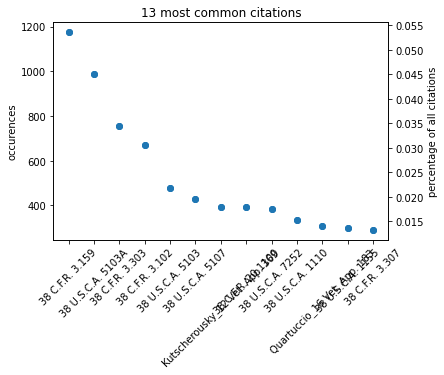

In [242]:
# select the 13 most common items
n = 13
most_common = counted.most_common(n)
# convert list of tuples to two lists
most_common_citations, most_common_counts = zip(*most_common)
# normalize most_common_counts by total number of citations
most_common_counts_normalized = [(i/len(flattened)) for i in most_common_counts]

# make the x axis labels diagonal
plt.xticks(rotation=45)

plt.scatter(most_common_citations, most_common_counts)
# show second y axis
plt.ylabel("occurences")

# show second y axis for normalized values
plt.twinx()
plt.scatter(most_common_citations, most_common_counts_normalized)
plt.ylabel("percentage of all citations")

plt.title(str(n) + ' most common citations')
plt.show()

from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=most_common_citations, y=most_common_counts, name="occurences"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=most_common_citations, y=most_common_counts_normalized, name="percentage of all citations", ),
    secondary_y=True,
)

title = "most common citations"
fig.update_layout(title_text=title)
fig.update_xaxes(title_text="citation")

fig.update_yaxes(title_text="percentage of all citations", secondary_y=True)
figures.append(fig)
fig.show()


In [243]:

n = 500
most_common = counted.most_common(n)
# convert list of tuples to two lists
most_common_citations, most_common_counts = zip(*most_common)
# normalize most_common_counts by total number of citations
most_common_counts_normalized = [(i/len(flattened)) for i in most_common_counts]
# sum of most common normalized
print("sum of most common normalized:", sum(most_common_counts_normalized))

# plot the partial sums of most common normalized
partial_sums = [sum(most_common_counts_normalized[:i+1]) for i in range(len(most_common_counts_normalized))]

# plot partial_sums as bar chart with plotly
fig = go.Figure(data=[go.Bar(y=partial_sums, name="partial sums")])
title = "partial sums of most common citations"
fig.update_layout(title_text=title)
figures.append(fig)
fig.show()

# print num unique citations
print("num unique citations:", len(counted))

sum of most common normalized: 0.9236484638526732


num unique citations: 1539


In [244]:
# mean of occurence count values
print(sum(list(counted.values()))/len(list(counted.values())))

14.254710851202079


In [245]:
# number of unique citations
print(len(list(counted.keys())))

1539


In [246]:
# show some least common occurances
least_common = counted.most_common()[-50:]
print("citation, occurences")
for el in least_common:
    print(el)

citation, occurences
('6 Vet. App. 38', 1)
('38 U.S.C.A. 7101', 1)
('Black_10 Vet. App. 284', 1)
('38 C.F.R. 4.29', 1)
('Mountford_24 Vet. App. 443', 1)
('706 F.2d 1563', 1)
('38 C.F.R. 20.800', 1)
('Mauerhan_16 Vet. App. 443', 1)
('Kyhn_716 F.3d 572', 1)
('Kyhn_23 Vet. App. 335', 1)
('716 F.3d 577', 1)
('Baxter_17 Vet. App. 407', 1)
('17 Vet. App. 410', 1)
('Kyhn_26 Vet. App. 371', 1)
('Deluca_8 Vet. App. 202', 1)
('Anglin_11 Vet. App. 361', 1)
('In_24 Vet. App. 40', 1)
('Gilbert_26 Vet. App. 48', 1)
('25 Vet. App. 234', 1)
('21 Vet. App. 352', 1)
('Buczynski_24 Vet. App. 221', 1)
('22 Vet. App. 111', 1)
('In_10 Vet. App. 125', 1)
('Dingess_19 Vet. App. 4739', 1)
('In_22 Vet. App. 128', 1)
('21 Vet. App. 112', 1)
('557 F.3d 1367', 1)
('Smith_2 Vet. App. 241', 1)
('8 U.S.C.A. 1153', 1)
('486 U.S. 800', 1)
('38 U.S.C.A. 7108', 1)
('Butler_960 F.2d 139', 1)
('Washington_21 Vet. App. 191', 1)
('Andrews_421 F.3d 1278', 1)
('Ephraim_82 F.3d 399', 1)
('Sears_16 Vet. App. 244', 1)
('Bruce_11 

## Document texts
### average number of words

In [235]:
count_words = lambda x: len(x.split(" "))
df['num_words'] = df['txt'].apply(count_words)

# plot num_word percentiles
bins = 10
percentiles = [i/bins for i in range(0, bins)]
num_words_per_percentile = df['num_words'].quantile(percentiles)

# make the same scatter plot in plotly
fig = px.scatter(x=percentiles, y=num_words_per_percentile, labels={"x": "percentile", "y": "avg number of words"})
fig.update_layout(title_text="percentiles of number of words per document")
figures.append(fig)
fig.show()


In [236]:
# average number of words
print(df['num_words'].mean())

2363.283


### citations per sentence: 
with an avg of ~20 citations and 2300 words per doc, and assuming 15 words per sentence there is a citation every ~7 sentences

### citation positions 
(relative to document length)
only for documents between length 800 and 1000

In [237]:
def normalize_nested_indices(x, txt):
    length = len(txt)
    tmp = find_all(txt, "@cit@")
    # find all indices of substring str in txt
    tmp = [el /length for el in tmp]
    return tmp

# drop docuements with num_words > 1000
df_short = df[df['num_words'] < 1500]
df_short = df_short[df_short['num_words'] > 1200]

df_short['normalized_indices'] = df_short.apply(lambda x: normalize_nested_indices(x['citation_indices'], x['txt']), axis=1)

flattened = flatten(df_short['normalized_indices'].to_list())

# draw same plot in plotly
fig = px.histogram(x=flattened, nbins=20)
fig.update_layout(title_text="Histogramm of normalized indices of citations per document")
fig.update_yaxes(title_text="Number of occurrences")
fig.update_xaxes(title_text="Normalized indices")
fig.show()

figures.append(fig)


In [238]:
with open('preprocessed_stats.html', 'a') as f:
    for fig in figures:
        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
